# Ejemplo 2 de Regresión: Árboles de decisión (árboles de regresión)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/oramosul/abd-files/blob/main/spark/3-spark-mllib/2-Regresion-Arboles.ipynb)

In [ ]:
# Solo si se corre en Google Colab
!pip install -q pyspark

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.regression import LinearRegression

spark = SparkSession.builder.getOrCreate()

In [ ]:
# Carga de archivos
!wget -q https://raw.githubusercontent.com/oramosul/abd-files/main/spark/datos/Clientes.csv

## 1.&nbsp;Lectura de Datos

Se examinará el dataset llamado "Clientes" que contiene datos del sitio web y de la aplicación móvil de una compañía. Se desea construir un modelo de regresión que prediga el gasto anual del cliente en los productos de la compañía.

In [ ]:
# Cargar los datos
df = spark.read.csv("Clientes.csv", inferSchema=True, header=True)

## 2.&nbsp;Pre-procesamiento

Para regresión con MLlib los datos deben encontrarse en dos columnas: `("etiquetas","atributos")`, donde `atributos` es una sola columna que contiene una lista con todos los atributos. Para poder crear esta columna `atributos` se debe agrupar los atributos usando un `VectorAssembler`.

In [ ]:
from pyspark.ml.feature import VectorAssembler

# Se utilizará los siguientes atributos bajo el nombre "atributos"
vassembler = VectorAssembler(inputCols=['Promedio sesion',
                                        'Tiempo en App',
                                        'Tiempo en SitioWeb',
                                        'Tiempo de Membresia'],
                             outputCol="Atributos")
# Aplicar a los datos
df2 = vassembler.transform(df)
# Conjunto de datos para regresión: "atributos, gasto anual"
df_final = df2.select("Atributos", 'Gasto Anual')
# Separación en conjunto de entrenamiento y evaluación
train_data, test_data = df_final.randomSplit([0.7, 0.3])

## 3.&nbsp;Entrenamiento del Modelo de Regresión

In [ ]:
from pyspark.ml.regression import DecisionTreeRegressor, RandomForestRegressor

In [ ]:
# Creación de un objeto de Regresión Lineal
dtreg = DecisionTreeRegressor(featuresCol="Atributos",
                              labelCol='Gasto Anual',
                              predictionCol= "Predicción")

# Entrenamiento del modelo (con el conjunto de entrenamiento)
modeloDT = dtreg.fit(train_data)

In [ ]:
modeloDT

DecisionTreeRegressionModel: uid=DecisionTreeRegressor_a154b2233769, depth=5, numNodes=61, numFeatures=4

Predicción en el conjunto de entrenamiento

In [ ]:
predicciones = modeloDT.transform(train_data)
predicciones.show(5, truncate=False)

+----------------------------------------------------------------------------+------------------+------------------+
|Atributos                                                                   |Gasto Anual       |Predicción        |
+----------------------------------------------------------------------------+------------------+------------------+
|[29.532428967057943,10.961298400154098,37.42021557502538,4.046423164299585] |408.6403510726275 |413.6215465839257 |
|[30.3931845423455,11.80298577760313,36.315763151803424,2.0838141920346707]  |319.9288698031936 |335.7749358193651 |
|[30.57436368417137,11.351049011250833,37.08884657968332,4.078308001651641]  |442.06441375806565|448.60275827287404|
|[30.81620064887634,11.851398743073142,36.925043038878634,1.0845853030221226]|266.086340948469  |335.7749358193651 |
|[31.04722213948752,11.199660962300452,38.688709099424365,3.0887639575315755]|392.4973991890214 |412.11775224469625|
+---------------------------------------------------------------

RMSE en el conjunto de entrenamiento

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

eval_rmse = RegressionEvaluator(labelCol="Gasto Anual", predictionCol="Predicción",
                                metricName="rmse")

eval_mae = RegressionEvaluator(labelCol="Gasto Anual", predictionCol="Predicción",
                               metricName="mae")

eval_mse = RegressionEvaluator(labelCol="Gasto Anual", predictionCol="Predicción",
                               metricName="mse")

eval_r2 = RegressionEvaluator(labelCol="Gasto Anual", predictionCol="Predicción",
                               metricName="r2")

In [ ]:
rmse = eval_rmse.evaluate(predicciones)
mae = eval_mae.evaluate(predicciones)
mse = eval_mse.evaluate(predicciones)
r2 = eval_r2.evaluate(predicciones)

print("MAE del conjunto de entrenamiento:", mae)
print("RMSE del conjunto de entrenamiento:", rmse)
print("MSE del conjunto de entrenamiento:", mse)
print("R^2 del conjunto de entrenamiento:", r2)

MAE del conjunto de entrenamiento: 20.093023285701516
RMSE del conjunto de entrenamiento: 25.343067842845958
MSE del conjunto de entrenamiento: 642.2710876870929
R^2 del conjunto de entrenamiento: 0.8985388847289566


Se realizará una figura de los valores reales ("Gasto Anual") y los valores predichos ("Predicción") para inspección visual de la predicción.

In [ ]:
import matplotlib.pyplot as plt

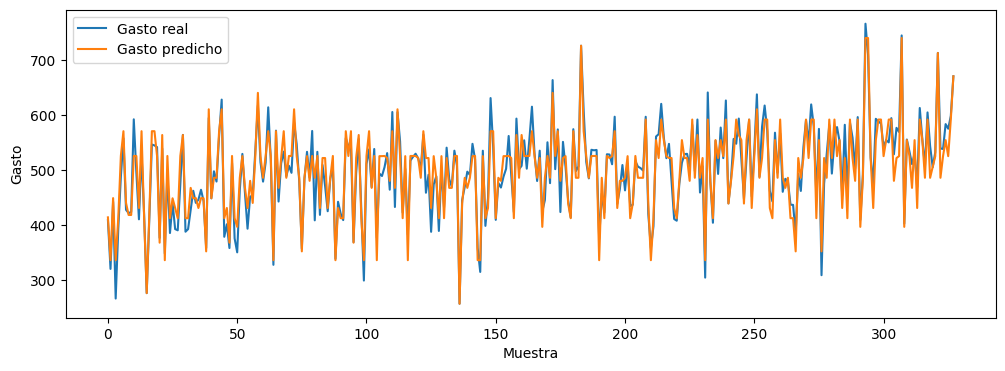

In [ ]:
# Recuperar las columnas de interés: Gasto Anual y Predicción
yreal = predicciones.select('Gasto Anual').collect()
ypred = predicciones.select('Predicción').collect()

# Figuras
plt.figure(figsize=(12, 4))
plt.plot(yreal)
plt.plot(ypred)
plt.legend(['Gasto real', 'Gasto predicho'])
plt.xlabel('Muestra'); plt.ylabel('Gasto');

## 4.&nbsp;Evaluación del Modelo

In [ ]:
# Aplicación del modelo entrenado al conjunto de prueba (test)
predicciones = modeloDT.transform(test_data)
predicciones.show(5, truncate=False)

+-----------------------------------------------------------------------------+-----------------+-----------------+
|Atributos                                                                    |Gasto Anual      |Predicción       |
+-----------------------------------------------------------------------------+-----------------+-----------------+
|[30.4925366965402,11.562936246652605,35.97656497174036,1.4816166268553612]   |282.4712457199145|335.7749358193651|
|[30.737720372628182,12.636606052000127,36.213763093698624,3.3578468423262944]|461.7807421962299|417.9638968743711|
|[30.83643267477343,13.100109538542807,35.907721429679654,3.361612984538193]  |467.5019004269896|417.9638968743711|
|[30.879484344127498,13.280432242922114,36.93615937845674,3.5851606351613436] |490.2065999848547|570.2089016591344|
|[30.971675643887767,11.731364294077403,36.07455114016891,4.4263640805293125] |494.6386097568927|525.1786854080075|
+-----------------------------------------------------------------------

In [ ]:
rmse = eval_rmse.evaluate(predicciones)
mae = eval_mae.evaluate(predicciones)
mse = eval_mse.evaluate(predicciones)
r2 = eval_r2.evaluate(predicciones)

print("MAE del conjunto de prueba:", mae)
print("RMSE del conjunto de prueba:", rmse)
print("MSE del conjunto de prueba:", mse)
print("R^2 del conjunto de prueba:", r2)

MAE del conjunto de prueba: 33.7937109242276
RMSE del conjunto de prueba: 42.112712638462
MSE del conjunto de prueba: 1773.4805657696768
R^2 del conjunto de prueba: 0.7126458393218829


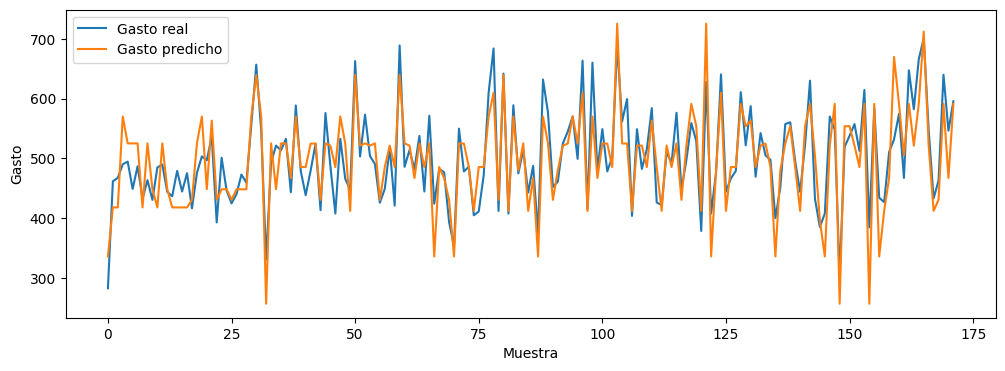

In [ ]:
# Recuperar las columnas de interés: Gasto Anual y Predicción
yreal = predicciones.select('Gasto Anual').collect()
ypred = predicciones.select('Predicción').collect()

# Figuras
plt.figure(figsize=(12, 4))
plt.plot(yreal)
plt.plot(ypred)
plt.legend(['Gasto real', 'Gasto predicho'])
plt.xlabel('Muestra'); plt.ylabel('Gasto');

## 5.&nbsp;Predicción

Una vez entrenado el modelo, se puede utilizar para predecir valores para nuevos conjuntos de datos. En este caso, para realizar esta prueba, se utilizará únicamente la columna de `Atributos` del conjunto de evaluación.

In [ ]:
# Datos para los cuales se realizará la predicción
df2 = test_data.select('Atributos')
df2.show(5, truncate=False)

+-----------------------------------------------------------------------------+
|Atributos                                                                    |
+-----------------------------------------------------------------------------+
|[30.4925366965402,11.562936246652605,35.97656497174036,1.4816166268553612]   |
|[30.737720372628182,12.636606052000127,36.213763093698624,3.3578468423262944]|
|[30.83643267477343,13.100109538542807,35.907721429679654,3.361612984538193]  |
|[30.879484344127498,13.280432242922114,36.93615937845674,3.5851606351613436] |
|[30.971675643887767,11.731364294077403,36.07455114016891,4.4263640805293125] |
+-----------------------------------------------------------------------------+
only showing top 5 rows



In [ ]:
# Predicciones sobre los datos
predicciones = modeloDT.transform(df2)

# Resultado
predicciones.show(5, truncate=False)

+-----------------------------------------------------------------------------+-----------------+
|Atributos                                                                    |Predicción       |
+-----------------------------------------------------------------------------+-----------------+
|[30.4925366965402,11.562936246652605,35.97656497174036,1.4816166268553612]   |335.7749358193651|
|[30.737720372628182,12.636606052000127,36.213763093698624,3.3578468423262944]|417.9638968743711|
|[30.83643267477343,13.100109538542807,35.907721429679654,3.361612984538193]  |417.9638968743711|
|[30.879484344127498,13.280432242922114,36.93615937845674,3.5851606351613436] |570.2089016591344|
|[30.971675643887767,11.731364294077403,36.07455114016891,4.4263640805293125] |525.1786854080075|
+-----------------------------------------------------------------------------+-----------------+
only showing top 5 rows

